## Simulation

In [ ]:
import numpy as np

def generate_markov_chain_sequence(initial_state, transition_matrix, steps):
    current_state = initial_state
    sequence = [current_state]

    for _ in range(steps - 1):
        current_state = np.random.choice(['normal', 'depressed', 'manic'], p=list(transition_matrix[current_state].values()))
        sequence.append(current_state)

    return sequence

def simulate_population(population_size, steps, transition_matrix):
    population = []
    for _ in range(population_size):
        initial_state = 'normal' 
        sequence = generate_markov_chain_sequence(initial_state, transition_matrix, steps)
        population.append(sequence)

    return population

def categorize_mental_health_state(markov_chain_output):
    consecutive_depression = 0
    has_mania = False
    has_two_consecutive_depression = False

    for state in markov_chain_output:
        if state == 'depressed':
            consecutive_depression += 1
            if consecutive_depression >= 2:
                has_two_consecutive_depression = True
        elif state == 'manic':
            has_mania = True
            consecutive_depression = 0  
        else:
            consecutive_depression = 0  

    if has_two_consecutive_depression and has_mania:
        return 'Mixed Bipolar'
    elif has_two_consecutive_depression:
        return 'MDD'
    elif has_mania:
        return 'Pure Mania'
    else:
        return 'Normal'

def analyze_population_distribution(population):
    distribution = {'Normal': 0, 'MDD': 0, 'Mixed Bipolar': 0, 'Pure Mania': 0}

    for sequence in population:
        category = categorize_mental_health_state(sequence)
        distribution[category] += 1

    return distribution

transition_matrix = {'normal': {'normal': 0.9947635315033879, 'depressed': 0.005236468496612034, 'manic': 0.0}, 'depressed': {'normal': 0.4961168967332019, 'depressed': 0.44711882565984223, 'manic': 0.05676427760695586}, 'manic': {'normal': 0.3144127430726594, 'depressed': 0.41431162105580444, 'manic': 0.27127563587153614}}


population_size = 1000
sequence_length = 52  # 52 weeks
num_simulations = 30

sum_percentages = {'Normal': 0, 'MDD': 0, 'Mixed Bipolar': 0, 'Pure Mania': 0}

for _ in range(num_simulations):
    simulated_population = simulate_population(population_size, sequence_length, transition_matrix)
    population_distribution = analyze_population_distribution(simulated_population)
    population_percentages = {k: (v / population_size) * 100 for k, v in population_distribution.items()}
    for category in sum_percentages:
        sum_percentages[category] += population_percentages[category]
average_percentages = {k: v / num_simulations for k, v in sum_percentages.items()}

average_percentages

{'Normal': 87.63683333333333,
 'MDD': 9.763700000000002,
 'Mixed Bipolar': 1.6119999999999997,
 'Pure Mania': 0.9874666666666668}

## DEAP

In [ ]:
import random
import numpy as np
from deap import base, creator, tools, algorithms

def generate_markov_chain_sequence(initial_state, transition_matrix, steps):
    current_state = initial_state
    sequence = [current_state]
    for _ in range(steps - 1):
        current_state = np.random.choice(['normal', 'depressed', 'manic'], p=list(transition_matrix[current_state].values()))
        sequence.append(current_state)
    return sequence

def simulate_population(population_size, steps, transition_matrix):
    population = []
    for _ in range(population_size):
        initial_state = 'normal'
        sequence = generate_markov_chain_sequence(initial_state, transition_matrix, steps)
        population.append(sequence)
    return population

def categorize_mental_health_state(markov_chain_output):
    consecutive_depression = 0
    has_mania = False
    has_two_consecutive_depression = False
    for state in markov_chain_output:
        if state == 'depressed':
            consecutive_depression += 1
            if consecutive_depression >= 2:
                has_two_consecutive_depression = True
        elif state == 'manic':
            has_mania = True
            consecutive_depression = 0  
        else:
            consecutive_depression = 0  
    if has_two_consecutive_depression and has_mania:
        return 'Mixed Bipolar'
    elif has_two_consecutive_depression:
        return 'MDD'
    elif has_mania:
        return 'Pure Mania'
    else:
        return 'Normal'

def analyze_population_distribution(population):
    distribution = {'Normal': 0, 'MDD': 0, 'Mixed Bipolar': 0, 'Pure Mania': 0}
    for sequence in population:
        category = categorize_mental_health_state(sequence)
        distribution[category] += 1
    return distribution


target_distribution = {'Normal': 87.5, 'MDD': 10, 'Mixed Bipolar': 2, 'Pure Mania': 0.5}

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

def generate_individual():
    return [random.random() for _ in range(9)]

toolbox.register("individual", tools.initIterate, creator.Individual, generate_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def normalize_probabilities(individual):
    for i in range(0, len(individual), 3):
        total = sum(max(0, p) for p in individual[i:i+3])  
        if total > 0:
            for j in range(3):
                individual[i+j] = max(0, individual[i+j]) / total
        else:
            individual[i:i+3] = [1/3, 1/3, 1/3]  
    return individual

def mutate(individual):
    for i in range(len(individual)):
        if random.random() < 0.1:  
            individual[i] += random.gauss(0, 0.1) 
            individual[i] = max(0, individual[i])  
    return individual,

toolbox.register("mutate", mutate)
toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("select", tools.selTournament, tournsize=3)


def evaluate(individual):
    individual = normalize_probabilities(individual)
    transition_matrix = {
        'normal': {'normal': individual[0], 'depressed': individual[1], 'manic': individual[2]},
        'depressed': {'normal': individual[3], 'depressed': individual[4], 'manic': individual[5]},
        'manic': {'normal': individual[6], 'depressed': individual[7], 'manic': individual[8]}
    }
    simulated_population = simulate_population(1000, 52, transition_matrix)
    population_distribution = analyze_population_distribution(simulated_population)
    population_percentages = {k: (v / 1000) * 100 for k, v in population_distribution.items()}
    fitness = -sum(abs(population_percentages[k] - target_distribution[k]) for k in target_distribution)
    return fitness,

toolbox.register("evaluate", evaluate)


population_size = 300
num_generations = 50

population = toolbox.population(n=population_size)

for gen in range(num_generations):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.1)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))


best_ind = tools.selBest(population, 1)[0]
best_transition_matrix = {
    'normal': {'normal': best_ind[0], 'depressed': best_ind[1], 'manic': best_ind[2]},
    'depressed': {'normal': best_ind[3], 'depressed': best_ind[4], 'manic': best_ind[5]},
    'manic': {'normal': best_ind[6], 'depressed': best_ind[7], 'manic': best_ind[8]}
}

print("Best Transition Matrix:", best_transition_matrix)


Best Transition Matrix: {'normal': {'normal': 0.9947635315033879, 'depressed': 0.005236468496612034, 'manic': 0.0}, 'depressed': {'normal': 0.4961168967332019, 'depressed': 0.44711882565984223, 'manic': 0.05676427760695586}, 'manic': {'normal': 0.3144127430726594, 'depressed': 0.41431162105580444, 'manic': 0.27127563587153614}}


# Beta Distribution

In [ ]:
import numpy as np

def generate_markov_chain_sequence(initial_state, transition_matrix, steps):
    current_state = initial_state
    sequence = [current_state]

    for _ in range(steps - 1):
        current_state = np.random.choice(['normal', 'depressed', 'manic'], p=list(transition_matrix[current_state].values()))
        sequence.append(current_state)

    return sequence
population = []
def simulate_population(population_size, steps, transition_matrix):
    
    for _ in range(population_size):
        initial_state = 'normal' 
        sequence = generate_markov_chain_sequence(initial_state, transition_matrix, steps)
        population.append(sequence)

    return population

def categorize_mental_health_state(markov_chain_output):
    consecutive_depression = 0
    has_mania = False
    has_two_consecutive_depression = False

    for state in markov_chain_output:
        if state == 'depressed':
            consecutive_depression += 1
            if consecutive_depression >= 2:
                has_two_consecutive_depression = True
        elif state == 'manic':
            has_mania = True
            consecutive_depression = 0  
        else:
            consecutive_depression = 0  

    if has_two_consecutive_depression and has_mania:
        return 'Mixed Bipolar'
    elif has_two_consecutive_depression:
        return 'MDD'
    elif has_mania:
        return 'Pure Mania'
    else:
        return 'Normal'

def analyze_population_distribution(population):
    distribution = {'Normal': 0, 'MDD': 0, 'Mixed Bipolar': 0, 'Pure Mania': 0}

    for sequence in population:
        category = categorize_mental_health_state(sequence)
        distribution[category] += 1

    return distribution


ftransition_matrix = {'normal': {'normal': 0.9947635315033879, 'depressed': 0.005236468496612034, 'manic': 0.0}, 'depressed': {'normal': 0.4961168967332019, 'depressed': 0.44711882565984223, 'manic': 0.05676427760695586}, 'manic': {'normal': 0.3144127430726594, 'depressed': 0.41431162105580444, 'manic': 0.27127563587153614}}
def mean_variance_to_alpha_beta(mean, variance):
    """Convert mean and variance of a Beta distribution to alpha and beta parameters."""
    alpha = ((1 - mean) / variance - 1 / mean) * mean**2
    beta = alpha * (1 / mean - 1)
    return alpha, beta

def normalize_transition_matrix(transition_matrix):
    """
    Normalize the rows of a transition matrix so that the values in each row add up to 1.

    Args:
    - transition_matrix (dict): A dictionary of dictionaries representing the transition matrix.

    Returns:
    - dict: A normalized transition matrix.
    """
    normalized_matrix = {}
    
    for state, transitions in transition_matrix.items():
        # Calculate the sum of the row values
        row_sum = sum(transitions.values())
        
        # Normalize each value in the row if row_sum is not zero
        if row_sum > 0:
            normalized_matrix[state] = {next_state: value / row_sum for next_state, value in transitions.items()}
        else:
            # Handle the case where row_sum is 0 to avoid division by zero
            # This could involve setting the transitions equally or some other logic
            num_transitions = len(transitions)
            normalized_matrix[state] = {next_state: 1 / num_transitions for next_state in transitions}
    
    return normalized_matrix

def new_value(old_value):
    variance = 1e-10
    if old_value == 0:
        old_value = 1e-6
    alpha, beta = mean_variance_to_alpha_beta(old_value, variance)
    return np.random.beta(alpha, beta)  # Example adjustment

# Iterate over the ftransition_matrix and update its values
for state in ftransition_matrix:
    for next_state in ftransition_matrix[state]:
        # Update the value with a new number
        old_value = ftransition_matrix[state][next_state]
        ftransition_matrix[state][next_state] = new_value(old_value)

transition_matrix = normalize_transition_matrix(ftransition_matrix)
print(transition_matrix)




population_size = 100000
sequence_length = 52  # 52 weeks
num_simulations = 1

sum_percentages = {'Normal': 0, 'MDD': 0, 'Mixed Bipolar': 0, 'Pure Mania': 0}

for _ in range(num_simulations):
    for i in range(population_size):
        simulated_population = simulate_population(1, sequence_length, transition_matrix)
    population_distribution = analyze_population_distribution(simulated_population)
    population_percentages = {k: (v / population_size) * 100 for k, v in population_distribution.items()}
    for category in sum_percentages:
        sum_percentages[category] += population_percentages[category]
average_percentages = {k: v / num_simulations for k, v in sum_percentages.items()}

average_percentages

{'normal': {'normal': 0.9947552154697274, 'depressed': 0.005244784530269323, 'manic': 3.1549462876539726e-15}, 'depressed': {'normal': 0.49611964750398774, 'depressed': 0.44711461479397935, 'manic': 0.05676573770203284}, 'manic': {'normal': 0.31441540592541145, 'depressed': 0.4143201461538295, 'manic': 0.27126444792075904}}


## Simulating Mental Health Disorder Transitions with Predisposition Variability in a Population Model

In [22]:
import numpy as np

def mean_variance_to_alpha_beta(mean, variance=1e-6):
    """Convert mean and variance of a Beta distribution to alpha and beta parameters."""
    # Adjust mean values very close to 0 or 1 to avoid division by zero or negative alpha/bet
    # Calculate alpha and beta using the adjusted mean
    alpha = mean * (mean * (1 - mean) / variance - 1)
    beta = (1 - mean) * (mean * (1 - mean) / variance - 1)
    if mean == 0:
        alpha , beta = 0
    return alpha, beta

def normalize_transition_matrix(transition_matrix):
    normalized_matrix = {}
    for state, transitions in transition_matrix.items():
        row_sum = sum(transitions.values())
        normalized_matrix[state] = {next_state: value / row_sum for next_state, value in transitions.items()}
    return normalized_matrix

def generate_and_normalize_transition_matrix(base_transition_matrix, variance=1e-6):
    individual_matrix = {}
    for state in base_transition_matrix:
        individual_matrix[state] = {}
        for next_state in base_transition_matrix[state]:
            old_value = base_transition_matrix[state][next_state] if base_transition_matrix[state][next_state] > 0 else 1e-9
            alpha, beta = mean_variance_to_alpha_beta(old_value, variance)
            # Ensure alpha and beta are positive
            if alpha > 0:
                new_value = np.random.beta(alpha, beta)
            else:
                new_value = 0
            individual_matrix[state][next_state] = new_value
    return normalize_transition_matrix(individual_matrix)

def generate_markov_chain_sequence(initial_state, transition_matrix, steps):
    current_state = initial_state
    sequence = [current_state]
    for _ in range(steps - 1):
        current_state = np.random.choice(['normal', 'depressed', 'manic'], p=list(transition_matrix[current_state].values()))
        sequence.append(current_state)
    return sequence

def simulate_population(population_size, steps, base_transition_matrix, predisposition_rate=0.1):
    population = []
    for _ in range(population_size):
        initial_state = 'normal'
        # Determine if the individual has a higher predisposition towards disorders
        if np.random.rand() < predisposition_rate:
            higher_predisposition = True
        else:
            higher_predisposition = False
        # Adjust variance based on predisposition
        variance = 1e-4 if higher_predisposition else 1e-6
        individual_matrix = generate_and_normalize_transition_matrix(base_transition_matrix, variance)
        sequence = generate_markov_chain_sequence(initial_state, individual_matrix, steps)
        population.append(sequence)
    return population


def categorize_mental_health_state(markov_chain_output):
    """Categorize the mental health state of an individual based on their Markov chain sequence."""
    consecutive_depression = 0
    has_mania = False
    has_two_consecutive_depression = False
    for state in markov_chain_output:
        if state == 'depressed':
            consecutive_depression += 1
            if consecutive_depression >= 2:
                has_two_consecutive_depression = True
        elif state == 'manic':
            has_mania = True
            consecutive_depression = 0
        else:
            consecutive_depression = 0
    if has_two_consecutive_depression and has_mania:
        return 'Mixed Bipolar'
    elif has_two_consecutive_depression:
        return 'MDD'
    elif has_mania:
        return 'Pure Mania'
    else:
        return 'Normal'

def analyze_population_distribution(population):
    """Analyze the distribution of mental health categories in the simulated population."""
    distribution = {'Normal': 0, 'MDD': 0, 'Mixed Bipolar': 0, 'Pure Mania': 0}
    for sequence in population:
        category = categorize_mental_health_state(sequence)
        distribution[category] += 1
    return distribution

# Base transition matrix
base_transition_matrix = {
    'normal': {'normal': 0.9947635315033878, 'depressed': 0.005236468496612034, 'manic': 0.0000000000000001},
    'depressed': {'normal': 0.4961168967332019, 'depressed': 0.44711882565984223, 'manic': 0.05676427760695586},
    'manic': {'normal': 0.3144127430726594, 'depressed': 0.41431162105580444, 'manic': 0.27127563587153614}
}


# Simulation parameters
population_size = 100000
sequence_length = 52  # For example, 52 weeks

# Simulate the population
simulated_population = simulate_population(population_size, sequence_length, base_transition_matrix)

# Analyze the population distribution
population_distribution = analyze_population_distribution(simulated_population)

# Display the results
print(population_distribution)


{'Normal': 87901, 'MDD': 9498, 'Mixed Bipolar': 1650, 'Pure Mania': 951}


In [23]:
total_population = sum(population_distribution.values())

# Calculate the percentage for each state
percentage_distribution = {state: (count / total_population) * 100 for state, count in population_distribution.items()}

percentage_distribution

{'Normal': 87.901,
 'MDD': 9.498,
 'Mixed Bipolar': 1.6500000000000001,
 'Pure Mania': 0.951}

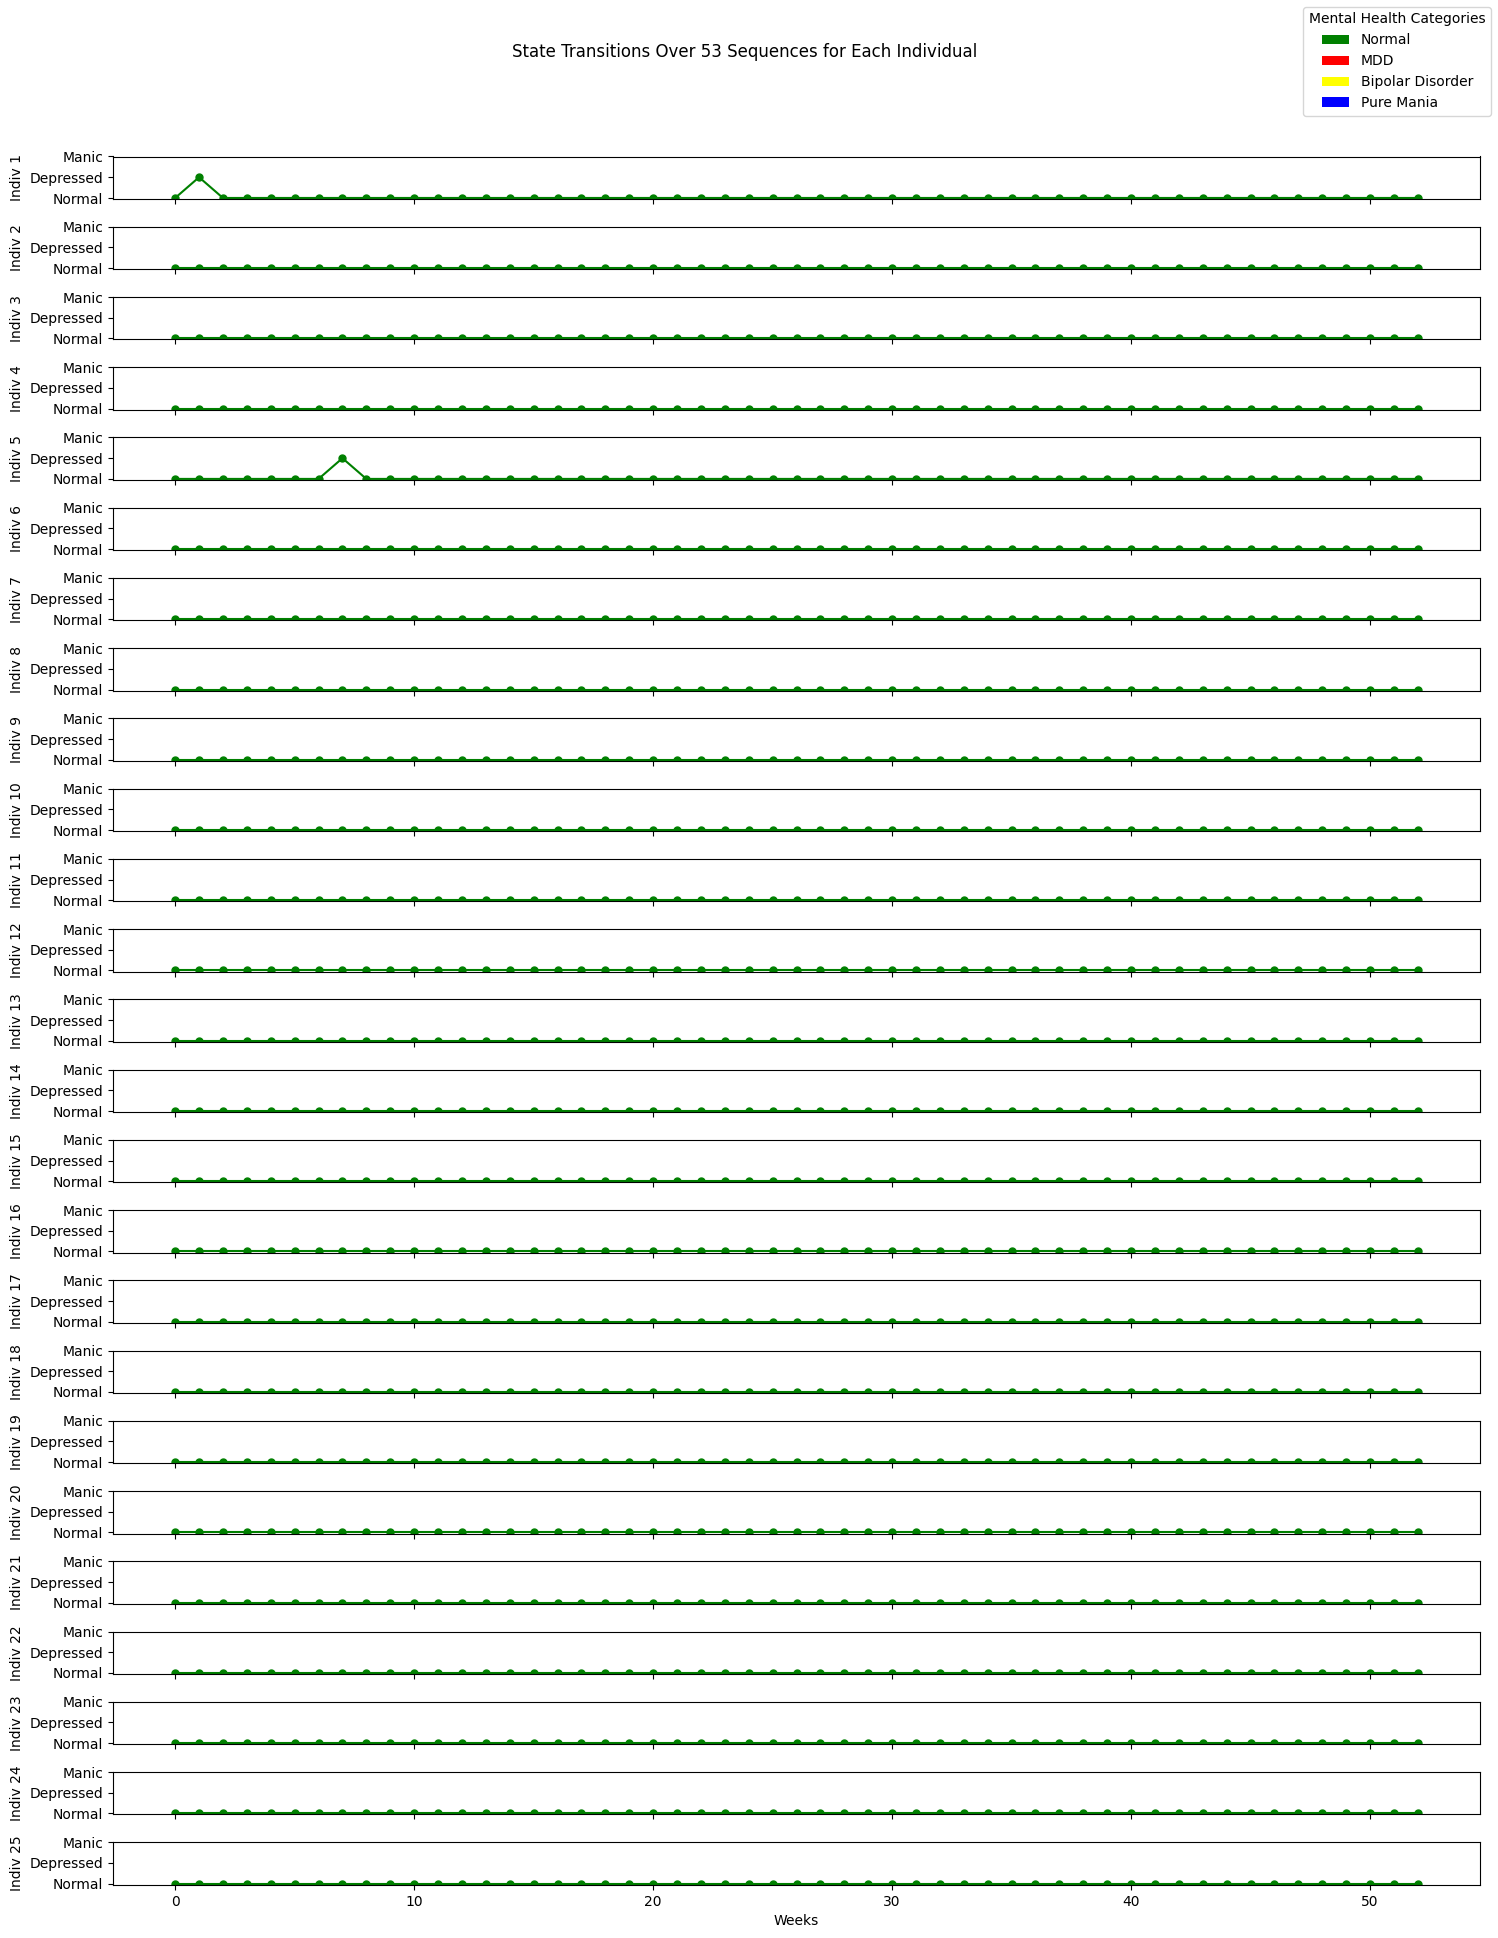

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def mean_variance_to_alpha_beta(mean, variance=1e-6):
    """Convert mean and variance of a Beta distribution to alpha and beta parameters."""
    mean = np.clip(mean, 1e-6, 1 - 1e-6)  # Adjust mean to avoid division by zero or negative values
    alpha = mean * (mean * (1 - mean) / variance - 1)
    beta = (1 - mean) * (mean * (1 - mean) / variance - 1)
    return alpha, beta

def normalize_transition_matrix(transition_matrix):
    normalized_matrix = {}
    for state, transitions in transition_matrix.items():
        row_sum = sum(transitions.values())
        normalized_matrix[state] = {next_state: value / row_sum for next_state, value in transitions.items()}
    return normalized_matrix

def generate_and_normalize_transition_matrix(base_transition_matrix, variance=1e-6):
    individual_matrix = {}
    for state in base_transition_matrix:
        individual_matrix[state] = {}
        for next_state, old_value in base_transition_matrix[state].items():
            if old_value <= 0:
                old_value = 1e-9
            alpha, beta = mean_variance_to_alpha_beta(old_value, variance)
            new_value = np.random.beta(alpha, beta) if alpha > 0 else 0
            individual_matrix[state][next_state] = new_value
    return normalize_transition_matrix(individual_matrix)

def generate_markov_chain_sequence(initial_state, transition_matrix, steps):
    current_state = initial_state
    sequence = [current_state]
    for _ in range(steps - 1):
        current_state = np.random.choice(['normal', 'depressed', 'manic'], p=list(transition_matrix[current_state].values()))
        sequence.append(current_state)
    return sequence

def simulate_population(population_size, steps, base_transition_matrix, predisposition_rate=0.1):
    population = []
    for _ in range(population_size):
        initial_state = 'normal'
        variance = 1e-4 if np.random.rand() < predisposition_rate else 1e-6
        individual_matrix = generate_and_normalize_transition_matrix(base_transition_matrix, variance)
        sequence = generate_markov_chain_sequence(initial_state, individual_matrix, steps)
        population.append(sequence)
    return population

def categorize_mental_health_state(markov_chain_output):
    consecutive_depression = 0
    has_mania = False
    has_two_consecutive_depression = False
    for state in markov_chain_output:
        if state == 'depressed':
            consecutive_depression += 1
            if consecutive_depression >= 2:
                has_two_consecutive_depression = True
        elif state == 'manic':
            has_mania = True
            consecutive_depression = 0
        else:
            consecutive_depression = 0
    if has_two_consecutive_depression and has_mania:
        return 'Bipolar Disorder'
    elif has_two_consecutive_depression:
        return 'MDD'
    elif has_mania:
        return 'Pure Mania'
    else:
        return 'Normal'

# Base transition matrix
base_transition_matrix = {
    'normal': {'normal': 0.9947635315033878, 'depressed': 0.005236468496612034, 'manic': 0.0000000000000001},
    'depressed': {'normal': 0.4961168967332019, 'depressed': 0.44711882565984223, 'manic': 0.05676427760695586},
    'manic': {'normal': 0.3144127430726594, 'depressed': 0.41431162105580444, 'manic': 0.27127563587153614}
}

# Simulation parameters
population_size = 25
sequence_length = 53

# Simulate the population
simulated_population = simulate_population(population_size, sequence_length, base_transition_matrix)

# Determine the final mental health category for each individual
final_categories = [categorize_mental_health_state(individual) for individual in simulated_population]

# Map final mental health categories to colors
category_to_color = {
    'Normal': 'green',
    'MDD': 'red',
    'Bipolar Disorder': 'yellow',
    'Pure Mania': 'blue'
}

# Visualization
fig, axes = plt.subplots(population_size, 1, figsize=(15, 20), sharex=True)

for i, sequence in enumerate(simulated_population):
    color = category_to_color[final_categories[i]]
    axes[i].plot(sequence, marker='o', linestyle='-', markersize=5, color=color)
    axes[i].set_yticks([0, 1, 2])
    axes[i].set_yticklabels(['Normal', 'Depressed', 'Manic'])
    axes[i].set_ylabel(f'Indiv {i+1}')

# Common labels and title
axes[-1].set_xlabel('Weeks')
fig.suptitle('State Transitions Over 53 Sequences for Each Individual')

# Legend for the categories
legend_elements = [Patch(facecolor=color, label=category) for category, color in category_to_color.items()]
fig.legend(handles=legend_elements, loc='upper right', title='Mental Health Categories')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def gather_required_examples(base_transition_matrix, target_per_category=2):
    categories = ['Normal', 'MDD', 'Bipolar Disorder', 'Pure Mania']
    category_examples = {category: [] for category in categories}
    attempts = 0
    
    while any(len(category_examples[cat]) < target_per_category for cat in categories):
        # Run a batch of simulations
        population = simulate_population(100, sequence_length, base_transition_matrix)
        categories_batch = [categorize_mental_health_state(individual) for individual in population]
        
        for seq, cat in zip(population, categories_batch):
            if len(category_examples[cat]) < target_per_category:
                category_examples[cat].append(seq)
        
        attempts += 1
        if attempts > 1000:  # Prevent infinite loop in case some categories are very unlikely
            break
    
    return category_examples

# Gather the required examples
required_examples = gather_required_examples(base_transition_matrix)

# Visualization
fig, axes = plt.subplots(8, 1, figsize=(10, 20), sharex=True)

# Map categories to colors and labels
category_to_label = ['Normal', 'MDD', 'Bipolar Disorder', 'Pure Mania']
category_to_color = {'Normal': 'green', 'MDD': 'red', 'Bipolar Disorder': 'orange', 'Pure Mania': 'blue'}
state_to_number = {'depressed': 0, 'normal': 1, 'manic': 2}

index = 0
for category in category_to_label:
    for sequence in required_examples[category][:2]:
        sequence_numbers = [state_to_number[state] for state in sequence]
        color = category_to_color[category]
        axes[index].plot(sequence_numbers, marker='o', linestyle='-', markersize=5, color=color)
        axes[index].set_yticks([0, 1, 2])
        axes[index].set_yticklabels(['Depressed', 'Normal', 'Manic'])
        axes[index].set_ylabel(f'{category} {index % 2 + 1}')
        index += 1

axes[-1].set_xlabel('Weeks')
fig.suptitle('Representative State Transitions Over Time')

# Legend for the categories
legend_elements = [Patch(facecolor=category_to_color[cat], label=cat) for cat in category_to_label]
fig.legend(handles=legend_elements, loc='upper right', title='Mental Health Categories')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


KeyError: 'Pure Mania'

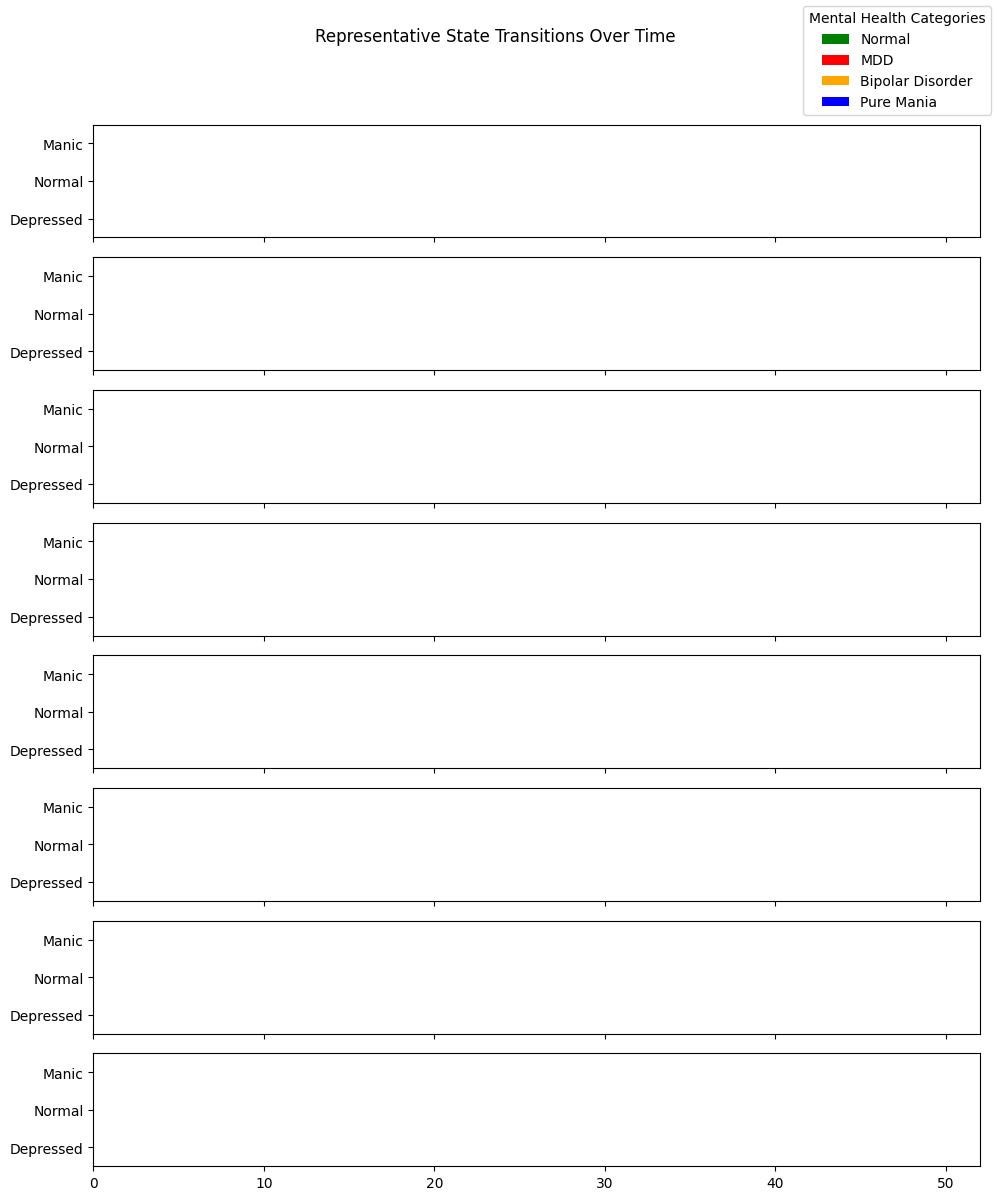

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.animation import FuncAnimation
category_to_label = ['Normal', 'MDD', 'Bipolar Disorder', 'Pure Mania']
# Define the state mapping and colors
state_to_number = {'depressed': 0, 'normal': 1, 'manic': 2}
category_to_color = {'Normal': 'green', 'MDD': 'red', 'Bipolar Disorder': 'orange', 'Pure Mania': 'blue'}

# Assume 'required_examples' is already populated with necessary data
# If needed, run the simulation and categorization process to obtain this

# Create a figure and axes for the animation
fig, axes = plt.subplots(8, 1, figsize=(10, 12.4), sharex=True)
lines = []

for ax in axes:
    line, = ax.plot([], [], marker='o', linestyle='-', markersize=5)
    ax.set_xlim(0, 52)
    ax.set_ylim(-0.5, 2.5)
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['Depressed', 'Normal', 'Manic'])
    lines.append(line)

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def update(frame):
    index = 0
    for category in category_to_label:
        for sequence in required_examples[category][:2]:
            sequence_numbers = [state_to_number[state] for state in sequence[:frame + 1]]
            lines[index].set_data(list(range(frame + 1)), sequence_numbers)
            lines[index].set_color(category_to_color[category])
            index += 1
    return lines
fig.suptitle('Representative State Transitions Over Time')

# Legend for the categories
legend_elements = [Patch(facecolor=category_to_color[cat], label=cat) for cat in category_to_label]
fig.legend(handles=legend_elements, loc='upper right', title='Mental Health Categories')

ani = FuncAnimation(fig, update, frames=sequence_length, init_func=init, blit=True)
plt.tight_layout(rect=[0, 0.03, 1, 0.94])
# Show or save the animation
plt.show()  # To display
# Save the animation as a GIF
ani.save('mental_health_transitions.gif', writer='pillow', fps=2)



In [3]:
def gather_customized_examples(base_transition_matrix, target_per_category=2):
    categories = ['Normal', 'MDD', 'Bipolar Disorder', 'Pure Mania']
    category_examples = {category: [] for category in categories}
    attempts = 0
    
    while any(len(category_examples[cat]) < target_per_category for cat in categories):
        # Run a batch of simulations
        population = simulate_population(100, sequence_length, base_transition_matrix)
        categories_batch = [categorize_mental_health_state(individual) for individual in population]
        
        for seq, cat in zip(population, categories_batch):
            if len(category_examples[cat]) >= target_per_category:
                continue
            
            # Custom filters for Normal and Pure Mania sequences
            if cat == 'Normal' and 'depressed' in seq and seq.count('depressed') == 1:
                # Check the sequence transitions to depressed only once and still categorized as Normal
                depressed_index = seq.index('depressed')
                if depressed_index > 0 and seq[depressed_index - 1] != 'depressed' and \
                   depressed_index < len(seq) - 1 and seq[depressed_index + 1] != 'depressed':
                    category_examples[cat].append(seq)
            elif cat == 'Pure Mania' and 'depressed' not in seq:
                category_examples[cat].append(seq)
            elif cat in ['MDD', 'Bipolar Disorder'] and len(category_examples[cat]) < target_per_category:
                category_examples[cat].append(seq)
        
        attempts += 1
        if attempts > 1000:  # Prevent infinite loop in case some categories are very unlikely
            break
    
    return category_examples

# Gather the required examples with custom filters
customized_examples = gather_customized_examples(base_transition_matrix)


In [4]:
customized_examples["Normal"][0]

['normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'depressed',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal']

In [6]:
required_examples["Normal"][0] = customized_examples["Normal"][0]

In [16]:
required_examples["Pure Mania"][1][5] = 'normal'

## PyTorch

#### Test

In [14]:
import numpy as np

def generate_markov_chain_sequence(initial_state, transition_matrix, steps):
    current_state = initial_state
    sequence = [current_state]

    for _ in range(steps - 1):
        current_state = np.random.choice(['normal', 'depressed', 'manic'], p=list(transition_matrix[current_state].values()))
        sequence.append(current_state)

    return sequence

def simulate_population(population_size, steps, transition_matrix):
    population = []
    for _ in range(population_size):
        initial_state = 'normal' 
        sequence = generate_markov_chain_sequence(initial_state, transition_matrix, steps)
        population.append(sequence)

    return population

def categorize_mental_health_state(markov_chain_output):
    consecutive_depression = 0
    has_mania = False
    has_two_consecutive_depression = False

    for state in markov_chain_output:
        if state == 'depressed':
            consecutive_depression += 1
            if consecutive_depression >= 2:
                has_two_consecutive_depression = True
        elif state == 'manic':
            has_mania = True
            consecutive_depression = 0  
        else:
            consecutive_depression = 0  

    if has_two_consecutive_depression and has_mania:
        return 'Mixed Bipolar'
    elif has_two_consecutive_depression:
        return 'MDD'
    elif has_mania:
        return 'Pure Mania'
    else:
        return 'Normal'

def analyze_population_distribution(population):
    distribution = {'Normal': 0, 'MDD': 0, 'Mixed Bipolar': 0, 'Pure Mania': 0}

    for sequence in population:
        category = categorize_mental_health_state(sequence)
        distribution[category] += 1

    return distribution
def normalize_transition_matrix(transition_matrix):
    normalized_matrix = {}
    for state, transitions in transition_matrix.items():
        total_probability = sum(transitions.values())
        normalized_transitions = {transition: prob / total_probability for transition, prob in transitions.items()}
        normalized_matrix[state] = normalized_transitions
    return normalized_matrix

transition_matrix = normalize_transition_matrix({'normal': {'normal': 0.94821674, 'depressed': 0.051783282, 'manic': 0.0}, 'depressed': {'normal': 0.46674925, 'depressed': 0.3644992, 'manic': 0.16875157}, 'manic': {'normal': 0.3820281, 'depressed': 0.33003527, 'manic': 0.28793666}})
population_size = 1000
sequence_length = 52  # 52 weeks
num_simulations = 30

sum_percentages = {'Normal': 0, 'MDD': 0, 'Mixed Bipolar': 0, 'Pure Mania': 0}

for _ in range(num_simulations):
    simulated_population = simulate_population(population_size, sequence_length, transition_matrix)
    population_distribution = analyze_population_distribution(simulated_population)
    population_percentages = {k: (v / population_size) * 100 for k, v in population_distribution.items()}
    for category in sum_percentages:
        sum_percentages[category] += population_percentages[category]
average_percentages = {k: v / num_simulations for k, v in sum_percentages.items()}

average_percentages


{'Normal': 25.486666666666668,
 'MDD': 26.299999999999997,
 'Mixed Bipolar': 36.193333333333335,
 'Pure Mania': 12.02}

#### Generate Markov Chain

In [1]:
import torch
import numpy as np
import random


torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

population_size = 100
genome_length = 9  
num_generations = 50
mutation_rate = 0.1
mutation_strength = 0.1
num_steps = 52  
target_distribution = torch.tensor([87.5, 10, 2, 0.5])

def initialize_population(population_size, genome_length):
    return torch.rand((population_size, genome_length), dtype=torch.float32)

def simulate_markov_chain(transition_matrix, num_steps=52):
    states = torch.tensor([0, 1, 2]) 
    sequence = []
    current_state = 0  
    for _ in range(num_steps):
        current_state = torch.multinomial(transition_matrix[current_state], 1).item()
        sequence.append(current_state)
    return sequence

def categorize_mental_health_state(sequence):
    consecutive_depression = 0
    has_mania = False
    state_counts = torch.zeros(4)  
    
    for state in sequence:
        if state == 1:  # depressed
            consecutive_depression += 1
        else:
            if consecutive_depression >= 2:
                state_counts[1] += 1  # MDD
            consecutive_depression = 0
        
        if state == 2:  # manic
            has_mania = True
        state_counts[state] += 1
    
    if has_mania and consecutive_depression >= 2:
        state_counts[2] += 1  # Mixed Bipolar
    elif has_mania:
        state_counts[3] += 1  # Pure Mania
    
    return state_counts

def evaluate_individual(individual):
    transition_matrix = individual.view(3, 3)
    transition_matrix /= transition_matrix.sum(dim=1, keepdim=True)
    
    state_counts = torch.zeros(4) 
    for _ in range(1000): 
        sequence = simulate_markov_chain(transition_matrix, num_steps=num_steps)
        state_counts += categorize_mental_health_state(sequence)
    
    
    simulated_distribution = (state_counts / state_counts.sum()) * 100
    fitness = -torch.sum(torch.abs(simulated_distribution - target_distribution))
    return fitness

def mutate(individual):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            noise = mutation_strength * torch.randn(1).item()
            individual[i] += noise
            individual[i] = torch.clamp(individual[i], 0, 1)
    return individual


population = initialize_population(population_size, genome_length)
for generation in range(num_generations):
    fitnesses = torch.tensor([evaluate_individual(ind) for ind in population])
    
    _, top_indices = torch.topk(fitnesses, population_size // 2)
    selected = population[top_indices]
    
    offspring = selected.clone()
    for i in range(len(offspring)):
        offspring[i] = mutate(offspring[i])
    
    population = torch.cat((selected, offspring), 0)

final_fitnesses = torch.tensor([evaluate_individual(ind) for ind in population])
best_index = torch.argmax(final_fitnesses)
best_individual = population[best_index]
best_transition_matrix = best_individual.view(3, 3) / best_individual.view(3, 3).sum(dim=1, keepdim=True)

print("Best Transition Matrix:", best_transition_matrix.numpy())
print("Best Fitness:", final_fitnesses[best_index].item())


Best Transition Matrix: [[0.95634323 0.0436568  0.        ]
 [0.34734133 0.46024776 0.19241092]
 [0.47813225 0.3268892  0.19497856]]
Best Fitness: -0.8053076267242432


In [11]:
matrix = best_transition_matrix.numpy()
states = ["normal", "depressed", "manic"]

matrix_dict = {}
for i, state_row in enumerate(states):
    row_dict = {}
    for j, state_col in enumerate(states):
        row_dict[state_col] = matrix[i, j]
    matrix_dict[state_row] = row_dict
print(matrix_dict)

{'normal': {'normal': 0.94821674, 'depressed': 0.051783282, 'manic': 0.0}, 'depressed': {'normal': 0.46674925, 'depressed': 0.3644992, 'manic': 0.16875157}, 'manic': {'normal': 0.3820281, 'depressed': 0.33003527, 'manic': 0.28793666}}


In [10]:
import torch
import numpy as np
import random

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

population_size = 100  # Increased population size for greater diversity
genome_length = 9
num_generations = 50
initial_mutation_rate = 0.1
mutation_strength = 0.1
num_steps = 52
target_distribution = torch.tensor([87.5, 10, 2, 0.5])

def initialize_population(population_size, genome_length):
    return torch.rand((population_size, genome_length), dtype=torch.float32)

def simulate_markov_chain(transition_matrix, num_steps=52):
    states = torch.tensor([0, 1, 2])
    sequence = []
    current_state = 0
    for _ in range(num_steps):
        current_state = torch.multinomial(transition_matrix[current_state], 1).item()
        sequence.append(current_state)
    return sequence

def categorize_mental_health_state(sequence):
    consecutive_depression = 0
    has_mania = False
    state_counts = torch.zeros(4)
    
    for state in sequence:
        if state == 1:  # depressed
            consecutive_depression += 1
        else:
            if consecutive_depression >= 2:
                state_counts[1] += 1  # MDD
            consecutive_depression = 0
        
        if state == 2:  # manic
            has_mania = True
        state_counts[state] += 1
    
    if has_mania and consecutive_depression >= 2:
        state_counts[2] += 1  # Mixed Bipolar
    elif has_mania:
        state_counts[3] += 1  # Pure Mania
    
    return state_counts

def evaluate_individual(individual):
    transition_matrix = individual.view(3, 3)
    transition_matrix /= transition_matrix.sum(dim=1, keepdim=True)
    
    state_counts = torch.zeros(4)
    for _ in range(1000):
        sequence = simulate_markov_chain(transition_matrix, num_steps=num_steps)
        state_counts += categorize_mental_health_state(sequence)
    
    simulated_distribution = (state_counts / state_counts.sum()) * 100
    fitness = -torch.sum((simulated_distribution - target_distribution) ** 2)  # MSE as loss function
    return fitness

def mutate(individual, mutation_rate):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            noise = mutation_strength * torch.randn(1).item()
            individual[i] += noise
            individual[i] = torch.clamp(individual[i], 0, 1)
    return individual

def crossover(parent1, parent2):
    cross_point = random.randint(0, genome_length)
    child1 = torch.cat((parent1[:cross_point], parent2[cross_point:]))
    child2 = torch.cat((parent2[:cross_point], parent1[cross_point:]))
    return child1, child2

population = initialize_population(population_size, genome_length)
mutation_rate = initial_mutation_rate

for generation in range(num_generations):
    fitnesses = torch.tensor([evaluate_individual(ind) for ind in population])
    
    _, top_indices = torch.topk(fitnesses, population_size // 2)
    selected = population[top_indices]
    
    offspring = []
    while len(offspring) < population_size // 2:
        parents = selected[torch.randperm(len(selected))[:2]]
        child1, child2 = crossover(parents[0], parents[1])
        offspring.append(mutate(child1, mutation_rate))
        offspring.append(mutate(child2, mutation_rate))
    
    population = torch.cat((selected, torch.stack(offspring)), 0)
    mutation_rate *= 0.95  # Decrease mutation rate over generations

final_fitnesses = torch.tensor([evaluate_individual(ind) for ind in population])
best_index = torch.argmax(final_fitnesses)
best_individual = population[best_index]
best_transition_matrix = best_individual.view(3, 3) / best_individual.view(3, 3).sum(dim=1, keepdim=True)

print("Best Transition Matrix:", best_transition_matrix.numpy())
print("Best Fitness:", final_fitnesses[best_index].item())


Best Transition Matrix: [[0.94821674 0.05178328 0.        ]
 [0.46674925 0.3644992  0.16875157]
 [0.3820281  0.33003527 0.28793666]]
Best Fitness: -0.15646162629127502


In [15]:
import torch
import torch.optim as optim

# Target distribution
target_distribution = torch.tensor([87.5, 10, 2, 0.5], dtype=torch.float32)

# Initialize transition matrix with requires_grad=True
transition_matrix = torch.rand((3, 3), requires_grad=True)

# Optimizer
optimizer = optim.Adam([transition_matrix], lr=0.01)

# Assuming a simplified, differentiable "evaluation" of the transition matrix
def evaluate_matrix(transition_matrix):
    # Simplify: Use the transition matrix to "estimate" a distribution
    # This is an abstract concept and not a direct simulation
    # The goal is to adjust this part to somehow reflect the impact of the transition matrix on state distribution
    distribution = torch.softmax(transition_matrix, dim=1).mean(dim=0)
    # Adding a dummy value to match the target distribution's size for demonstration
    distribution = torch.cat((distribution, torch.tensor([0.0])), 0) * 100
    return distribution

# Loss function
def loss_function(predicted_distribution, target_distribution):
    return torch.sum((predicted_distribution - target_distribution) ** 2)

# Training loop
num_epochs = 100000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Evaluate the transition matrix (abstractly)
    predicted_distribution = evaluate_matrix(transition_matrix)
    
    # Compute loss
    loss = loss_function(predicted_distribution, target_distribution)
    
    # Backpropagation
    loss.backward()
    
    # Update transition matrix
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Print optimized transition matrix
optimized_matrix = torch.softmax(transition_matrix, dim=1).detach().numpy()
print("Optimized Transition Matrix:\n", optimized_matrix)


Epoch 0, Loss: 4026.4482421875
Epoch 100, Loss: 381.12384033203125
Epoch 200, Loss: 63.69922637939453
Epoch 300, Loss: 25.313732147216797
Epoch 400, Loss: 15.740907669067383
Epoch 500, Loss: 11.35770034790039
Epoch 600, Loss: 8.462601661682129
Epoch 700, Loss: 6.355507850646973
Epoch 800, Loss: 4.810848236083984
Epoch 900, Loss: 3.6783719062805176
Epoch 1000, Loss: 2.844119071960449
Epoch 1100, Loss: 2.2253241539001465
Epoch 1200, Loss: 1.7631316184997559
Epoch 1300, Loss: 1.4157249927520752
Epoch 1400, Loss: 1.1532073020935059
Epoch 1500, Loss: 0.9540234804153442
Epoch 1600, Loss: 0.8024595379829407
Epoch 1700, Loss: 0.6869498491287231
Epoch 1800, Loss: 0.5988850593566895
Epoch 1900, Loss: 0.5318020582199097
Epoch 2000, Loss: 0.48080864548683167
Epoch 2100, Loss: 0.44217175245285034
Epoch 2200, Loss: 0.4130287170410156
Epoch 2300, Loss: 0.3911735415458679
Epoch 2400, Loss: 0.3748927116394043
Epoch 2500, Loss: 0.36286798119544983
Epoch 2600, Loss: 0.35406559705734253
Epoch 2700, Loss: 

In [44]:
transition_matrix_optimized = np.array(optimized_matrix_corrected)
state_names = ['normal', 'depressed', 'manic']
transition_matrix = {state: {state_names[i]: transition_matrix_optimized[idx, i] for i in range(len(state_names))} for idx, state in enumerate(state_names)}
# Simulation parameters
population_size = 1000
sequence_length = 52  # 52 weeks
num_simulations = 30

# Initialize sum of percentages


# Simulate and calculate average percentages
import numpy as np

def generate_markov_chain_sequence(initial_state, transition_matrix, steps):
    current_state = initial_state
    sequence = [current_state]

    for _ in range(steps - 1):
        current_state = np.random.choice(['normal', 'depressed', 'manic'], p=list(transition_matrix[current_state].values()))
        sequence.append(current_state)

    return sequence

def simulate_population(population_size, steps, transition_matrix):
    population = []
    for _ in range(population_size):
        initial_state = 'normal' 
        sequence = generate_markov_chain_sequence(initial_state, transition_matrix, steps)
        population.append(sequence)

    return population

def categorize_mental_health_state(markov_chain_output):
    consecutive_depression = 0
    has_mania = False
    has_two_consecutive_depression = False

    for state in markov_chain_output:
        if state == 'depressed':
            consecutive_depression += 1
            if consecutive_depression >= 2:
                has_two_consecutive_depression = True
        elif state == 'manic':
            has_mania = True
            consecutive_depression = 0  
        else:
            consecutive_depression = 0  

    if has_two_consecutive_depression and has_mania:
        return 'Mixed Bipolar'
    elif has_two_consecutive_depression:
        return 'MDD'
    elif has_mania:
        return 'Pure Mania'
    else:
        return 'Normal'

def analyze_population_distribution(population):
    distribution = {'Normal': 0, 'MDD': 0, 'Mixed Bipolar': 0, 'Pure Mania': 0}
    for sequence in population:
        category = categorize_mental_health_state(sequence)
        distribution[category] += 1

    return distribution




population_size = 1000
sequence_length = 52  # 52 weeks
num_simulations = 30

sum_percentages = {'Normal': 0, 'MDD': 0, 'Mixed Bipolar': 0, 'Pure Mania': 0}

for _ in range(num_simulations):
    simulated_population = simulate_population(population_size, sequence_length, transition_matrix)
    population_distribution = analyze_population_distribution(simulated_population)
    population_percentages = {k: (v / population_size) * 100 for k, v in population_distribution.items()}
    for category in sum_percentages:
        sum_percentages[category] += population_percentages[category]
average_percentages = {k: v / num_simulations for k, v in sum_percentages.items()}

average_percentages

ValueError: probabilities do not sum to 1

In [29]:
import torch
import torch.optim as optim

# Adjust the target distribution to reflect probabilities
target_distribution = torch.tensor([0.875, 0.1, 0.02, 0.005], dtype=torch.float32)

# Initialize transition matrix
transition_matrix = torch.rand((3, 3), requires_grad=True)

# Optimizer
optimizer = optim.Adam([transition_matrix], lr=0.01)

def proxy_for_categorization(transition_matrix):
    # Example metric for demonstration
    depressed_state_prob = transition_matrix[:, 1].mean()
    return depressed_state_prob

def proxy_objective(transition_matrix, target_distribution):
    categorization_proxy = proxy_for_categorization(transition_matrix)
    distribution_proxy = torch.softmax(transition_matrix, dim=1).mean(dim=0)
    distribution_proxy_padded = torch.cat((distribution_proxy, torch.tensor([0.0])))

    # Adjust the scale if necessary
    distribution_proxy_padded *= target_distribution.sum()

    # Component losses
    loss_distribution = torch.sum((distribution_proxy_padded - target_distribution) ** 2)
    loss_categorization = categorization_proxy

    # Regularization to discourage extreme probabilities
    regularization = torch.sum(torch.abs(transition_matrix - 1/3))  # Encourage diversity

    # Combine losses with regularization
    return loss_distribution + loss_categorization + 0.01 * regularization  # Adjust weighting as needed

# Optimization loop
for epoch in range(10000):  # Adjusted for demonstration
    optimizer.zero_grad()
    transition_matrix_normalized = torch.softmax(transition_matrix, dim=1)
    loss = proxy_objective(transition_matrix_normalized, target_distribution)
    loss.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

print("Optimized Transition Matrix:", transition_matrix_normalized.detach().numpy())


Epoch 0, Loss: 0.688603937625885
Epoch 1000, Loss: 0.1833253800868988
Epoch 2000, Loss: 0.18008270859718323
Epoch 3000, Loss: 0.17932716012001038
Epoch 4000, Loss: 0.1790364384651184
Epoch 5000, Loss: 0.17889882624149323
Epoch 6000, Loss: 0.17882651090621948
Epoch 7000, Loss: 0.17878611385822296
Epoch 8000, Loss: 0.17876282334327698
Epoch 9000, Loss: 0.17874912917613983
Optimized Transition Matrix: [[9.9998271e-01 9.8688897e-06 7.3983542e-06]
 [9.9998367e-01 6.8766967e-06 9.4387733e-06]
 [9.9998581e-01 7.4909431e-06 6.6978128e-06]]


In [33]:
import torch
import torch.optim as optim

# Assume these conditions we're trying to optimize towards
target_distribution = torch.tensor([87.5, 10, 2, 0.5], dtype=torch.float32)

# Initialize transition matrix
transition_matrix = torch.rand((3, 3), requires_grad=True)

# Optimizer
optimizer = optim.Adam([transition_matrix], lr=0.01)

def proxy_for_categorization(transition_matrix):
    # Simplified proxy metric for demonstration
    depressed_state_prob = transition_matrix[:, 1].mean()
    return depressed_state_prob

def proxy_objective(transition_matrix, target_distribution):
    categorization_proxy = proxy_for_categorization(transition_matrix)
    
    # Adjusting the distribution proxy to match the target distribution size
    distribution_proxy = torch.softmax(transition_matrix, dim=1).mean(dim=0)
    # Append a dummy value to ensure the size matches the target_distribution
    distribution_proxy_padded = torch.cat((distribution_proxy, torch.tensor([0.0])))

    # Rescale to match the scale of the target distribution
    distribution_proxy_padded *= 100

    # Calculate the loss as a combination of distribution fit and categorization proxy
    loss_distribution = torch.sum((distribution_proxy_padded - target_distribution) ** 2)
    loss_categorization = categorization_proxy
    
    # Introduce state-specific adjustments to encourage diverse behaviors
    state_specific_loss = 0.0
    for i in range(transition_matrix.size(0)):
        for j in range(transition_matrix.size(1)):
            if i != j:  # Encourage transitions to other states
                state_specific_loss += transition_matrix[i, j]
    
    # Combine losses with a weight for state-specific adjustments
    return loss_distribution + loss_categorization + 0.01 * state_specific_loss

# Optimization loop
for epoch in range(1000000):  # Adjust number of epochs as necessary
    optimizer.zero_grad()
    
    # Normalize the transition matrix for the calculation
    transition_matrix_normalized = torch.softmax(transition_matrix, dim=1)
    
    # Calculate proxy objective
    loss = proxy_objective(transition_matrix_normalized, target_distribution)
    
    # Backpropagate and update
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:  # Adjust logging frequency as necessary
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Print the optimized transition matrix
optimized_matrix = torch.softmax(transition_matrix, dim=1).detach().numpy()
print("Optimized Transition Matrix:", optimized_matrix)


Epoch 0, Loss: 4644.89306640625
Epoch 100, Loss: 2378.59521484375
Epoch 200, Loss: 1735.20166015625
Epoch 300, Loss: 1572.6962890625
Epoch 400, Loss: 1505.935302734375
Epoch 500, Loss: 1471.0352783203125
Epoch 600, Loss: 1450.1300048828125
Epoch 700, Loss: 1436.458251953125
Epoch 800, Loss: 1426.9510498046875
Epoch 900, Loss: 1420.03173828125
Epoch 1000, Loss: 1414.815673828125
Epoch 1100, Loss: 1410.772216796875
Epoch 1200, Loss: 1407.5660400390625
Epoch 1300, Loss: 1404.974365234375
Epoch 1400, Loss: 1402.8470458984375
Epoch 1500, Loss: 1401.0762939453125
Epoch 1600, Loss: 1399.5848388671875
Epoch 1700, Loss: 1398.31591796875
Epoch 1800, Loss: 1397.226806640625
Epoch 1900, Loss: 1396.2841796875
Epoch 2000, Loss: 1395.46240234375
Epoch 2100, Loss: 1394.7413330078125
Epoch 2200, Loss: 1394.10546875
Epoch 2300, Loss: 1393.5416259765625
Epoch 2400, Loss: 1393.0389404296875
Epoch 2500, Loss: 1392.589111328125
Epoch 2600, Loss: 1392.18505859375
Epoch 2700, Loss: 1391.820556640625
Epoch 280

In [38]:
import torch
import torch.optim as optim

# Initialize transition matrix from the provided probabilities
initial_probs = torch.tensor([
    [0.9947635315033879, 0.005236468496612034, 0.0],
    [0.4961168967332019, 0.44711882565984223, 0.05676427760695586],
    [0.3144127430726594, 0.41431162105580444, 0.27127563587153614]
], dtype=torch.float32)

transition_matrix = torch.nn.Parameter(initial_probs.clone())

# Optimizer
optimizer = optim.Adam([transition_matrix], lr=0.01)

# Regularization to maintain realism
def regularization_loss(transition_matrix, initial_matrix, weight=0.1):
    return weight * torch.sum((transition_matrix - initial_matrix) ** 2)

# Combined loss function
def combined_loss(transition_matrix, initial_matrix, target_distribution, weight=0.1):
    # Normalize the transition matrix
    transition_matrix_normalized = torch.softmax(transition_matrix, dim=1)
    
    # Simplified approach to calculate a proxy for the desired outcome
    # Adjust as necessary to better match your specific goals
    simulated_distribution = transition_matrix_normalized.mean(dim=0)
    simulated_distribution_padded = torch.cat((simulated_distribution, torch.tensor([0.0])))
    simulated_distribution_padded *= 100
    
    # Distribution loss
    loss_distribution = torch.sum((simulated_distribution_padded - target_distribution) ** 2)
    
    # Regularization to stay close to the initial model
    loss_reg = regularization_loss(transition_matrix, initial_matrix, weight)
    
    return loss_distribution + loss_reg

# Target distribution
target_distribution = torch.tensor([87.5, 10, 2, 0.5], dtype=torch.float32)

# Optimization loop
for epoch in range(5000):
    optimizer.zero_grad()
    loss = combined_loss(transition_matrix, initial_probs, target_distribution, weight=0.05)
    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Output the optimized transition matrix
optimized_matrix = torch.softmax(transition_matrix, dim=1).detach().numpy()
print("Optimized Transition Matrix:", optimized_matrix)


Epoch 0, Loss: 3014.6708984375
Epoch 500, Loss: 9.078529357910156
Epoch 1000, Loss: 2.6979293823242188
Epoch 1500, Loss: 1.4928014278411865
Epoch 2000, Loss: 1.245932698249817
Epoch 2500, Loss: 1.199230670928955
Epoch 3000, Loss: 1.190899133682251
Epoch 3500, Loss: 1.187523603439331
Epoch 4000, Loss: 1.1839338541030884
Epoch 4500, Loss: 1.1795897483825684
Optimized Transition Matrix: [[0.9223019  0.05809506 0.01960298]
 [0.8565768  0.12109431 0.02232888]
 [0.8499495  0.12486157 0.02518889]]


In [67]:
for i in range(optimized_matrix.shape[0]):
    row_sum = np.sum(optimized_matrix[i])
    optimized_matrix[i] = optimized_matrix[i] / row_sum

# Verify the row sums
row_sums = np.sum(optimized_matrix, axis=1)
print("Row sums after normalization:", row_sums)

# Display the normalized optimized matrix
print("Normalized Optimized Transition Matrix:\n", optimized_matrix)

Row sums after normalization: [1. 1. 1.]
Normalized Optimized Transition Matrix:
 [[0.9223019  0.05809506 0.0196031 ]
 [0.8565768  0.12109431 0.02232894]
 [0.8499495  0.12486157 0.02518895]]


In [71]:
def normalize_transition_matrix(transition_matrix):
    normalized_matrix = {}
    for state, transitions in transition_matrix.items():
        total_probability = sum(transitions.values())
        normalized_transitions = {transition: prob / total_probability for transition, prob in transitions.items()}
        normalized_matrix[state] = normalized_transitions
    return normalized_matrix
transition_matrix_optimized = np.array(optimized_matrix)
state_names = ['normal', 'depressed', 'manic']
transition_matrix = normalize_transition_matrix({state: {state_names[i]: transition_matrix_optimized[idx, i] for i in range(len(state_names))} for idx, state in enumerate(state_names)})
# Simulation parameters
population_size = 1000
sequence_length = 52  # 52 weeks
num_simulations = 30

# Initialize sum of percentages


# Simulate and calculate average percentages
import numpy as np

def generate_markov_chain_sequence(initial_state, transition_matrix, steps):
    current_state = initial_state
    sequence = [current_state]

    for _ in range(steps - 1):
        current_state = np.random.choice(['normal', 'depressed', 'manic'], p=list(transition_matrix[current_state].values()))
        sequence.append(current_state)

    return sequence

def simulate_population(population_size, steps, transition_matrix):
    population = []
    for _ in range(population_size):
        initial_state = 'normal' 
        sequence = generate_markov_chain_sequence(initial_state, transition_matrix, steps)
        population.append(sequence)

    return population

def categorize_mental_health_state(markov_chain_output):
    consecutive_depression = 0
    has_mania = False
    has_two_consecutive_depression = False

    for state in markov_chain_output:
        if state == 'depressed':
            consecutive_depression += 1
            if consecutive_depression >= 2:
                has_two_consecutive_depression = True
        elif state == 'manic':
            has_mania = True
            consecutive_depression = 0  
        else:
            consecutive_depression = 0  

    if has_two_consecutive_depression and has_mania:
        return 'Mixed Bipolar'
    elif has_two_consecutive_depression:
        return 'MDD'
    elif has_mania:
        return 'Pure Mania'
    else:
        return 'Normal'

def analyze_population_distribution(population):
    distribution = {'Normal': 0, 'MDD': 0, 'Mixed Bipolar': 0, 'Pure Mania': 0}
    for sequence in population:
        category = categorize_mental_health_state(sequence)
        distribution[category] += 1

    return distribution




population_size = 1000
sequence_length = 52  # 52 weeks
num_simulations = 30

sum_percentages = {'Normal': 0, 'MDD': 0, 'Mixed Bipolar': 0, 'Pure Mania': 0}

for _ in range(num_simulations):
    simulated_population = simulate_population(population_size, sequence_length, transition_matrix)
    population_distribution = analyze_population_distribution(simulated_population)
    population_percentages = {k: (v / population_size) * 100 for k, v in population_distribution.items()}
    for category in sum_percentages:
        sum_percentages[category] += population_percentages[category]
average_percentages = {k: v / num_simulations for k, v in sum_percentages.items()}

average_percentages

{'Normal': 25.04333333333334,
 'MDD': 10.873333333333331,
 'Mixed Bipolar': 18.59,
 'Pure Mania': 45.493333333333325}